In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from wasserstein import PairwiseEMD
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import leaves_list
from matplotlib.colors import PowerNorm

In [2]:
datadir = os.path.join('..', 'data', 'modeling', 'predict')
adata = sc.read_h5ad(os.path.join(datadir, 'training.h5ad'))
adata

AnnData object with n_obs × n_vars = 1575028 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score'

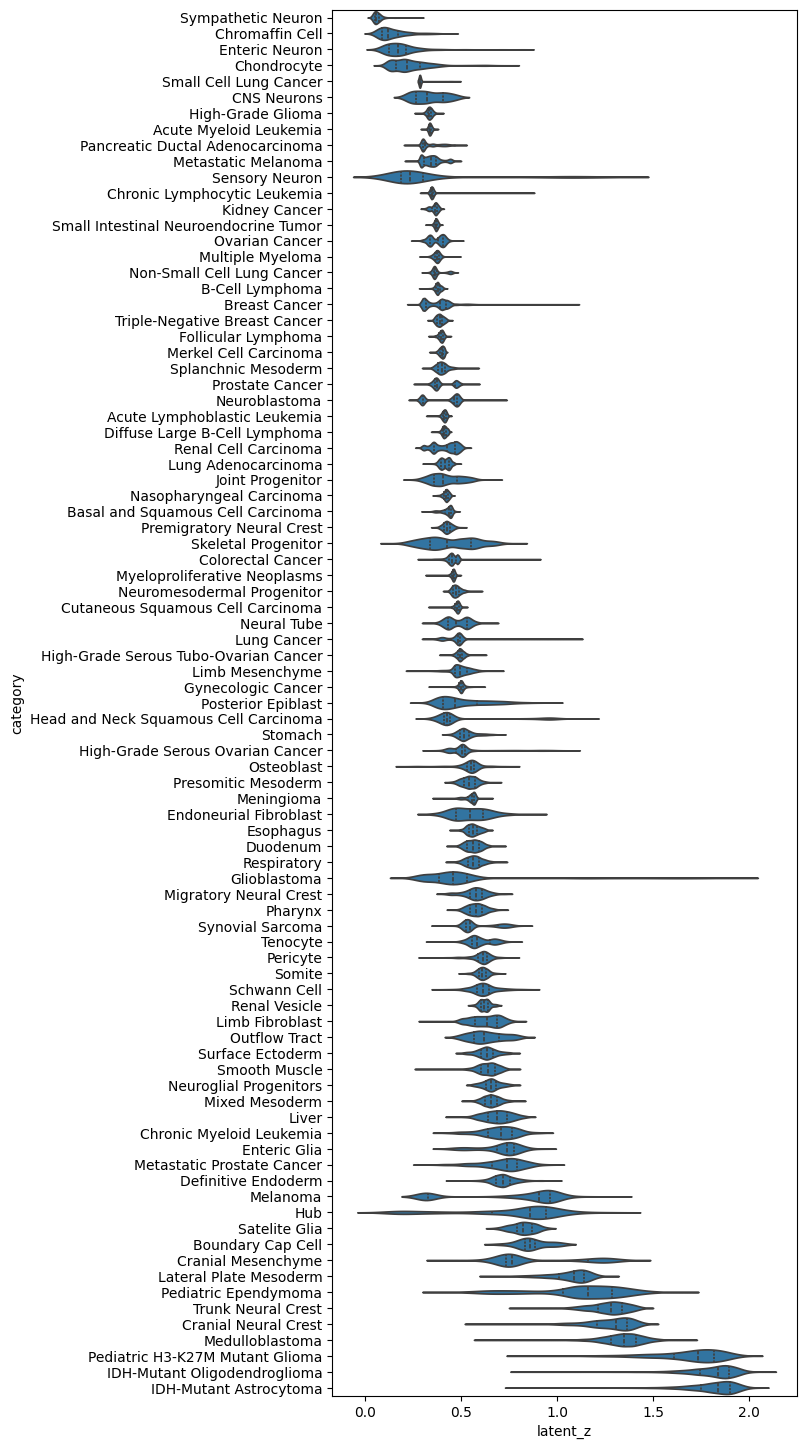

In [ ]:
df_cat = adata.obs.groupby('category')
df_z = df_cat.latent_z.mean()

fig, ax = plt.subplots(1, 1, figsize = (6, 18))
sns.violinplot(
    adata.obs,
    x = 'latent_z',
    y = 'category',
    order = df_z.sort_values().index,
    density_norm = 'width',
    inner = 'quart',
    ax = ax)
plt.show()

In [6]:
# pairwise wasserstein distances
num_q = 500
qq = (np.arange(num_q) + .5) / num_q
cat_names = [None] * len(df_cat)
cat_events = [None] * len(df_cat)
for i, (cat, df) in enumerate(df_cat):
    cat_events[i] = np.fliplr(
                    np.column_stack(
                    np.unique(
                        np.quantile(df.latent_z, qq),
                        return_counts = True)))
    cat_names[i] = cat

emd = PairwiseEMD(norm = True)
emd(cat_events)
dist = emd.emds()

Finished preprocessing 87 events in 0.0013s
   375 / 3741  EMDs computed  -  10.02% completed - 1.008s
   750 / 3741  EMDs computed  -  20.05% completed - 1.607s
  1125 / 3741  EMDs computed  -  30.07% completed - 2.150s
  1500 / 3741  EMDs computed  -  40.10% completed - 2.980s
  1875 / 3741  EMDs computed  -  50.12% completed - 3.664s
  2250 / 3741  EMDs computed  -  60.14% completed - 4.268s
  2625 / 3741  EMDs computed  -  70.17% completed - 5.104s
  3000 / 3741  EMDs computed  -  80.19% completed - 5.874s
  3375 / 3741  EMDs computed  -  90.22% completed - 6.399s
  3741 / 3741  EMDs computed  - 100.00% completed - 7.247s


In [7]:
# distances — cancer vs. development
msk_cancer = (adata.obs.celltype == 'Malignant')
cat_cancer = adata[msk_cancer].obs.category.cat.categories.tolist()
cat_dev = adata[~msk_cancer].obs.category.cat.categories.tolist()
cat_cancer.append('latent_z'); cat_dev.append('latent_z')
df = pd.DataFrame(dist, index = cat_names, columns = cat_names)
df = pd.concat((df, df_z), axis = 1).T.join(df_z)
df = df.loc[cat_cancer, cat_dev]
df.loc['latent_z', 'latent_z'] = 0.

# cluster cancer
method = 'average'
Z_row = linkage(df, method = method, optimal_ordering = True)
df = df.iloc[leaves_list(Z_row)]

# cluster development
Z_col = linkage(df.T, method = method, optimal_ordering = True)
df = df.iloc[:, leaves_list(Z_col)]
df = df.drop('latent_z', axis = 0).drop('latent_z', axis = 1)

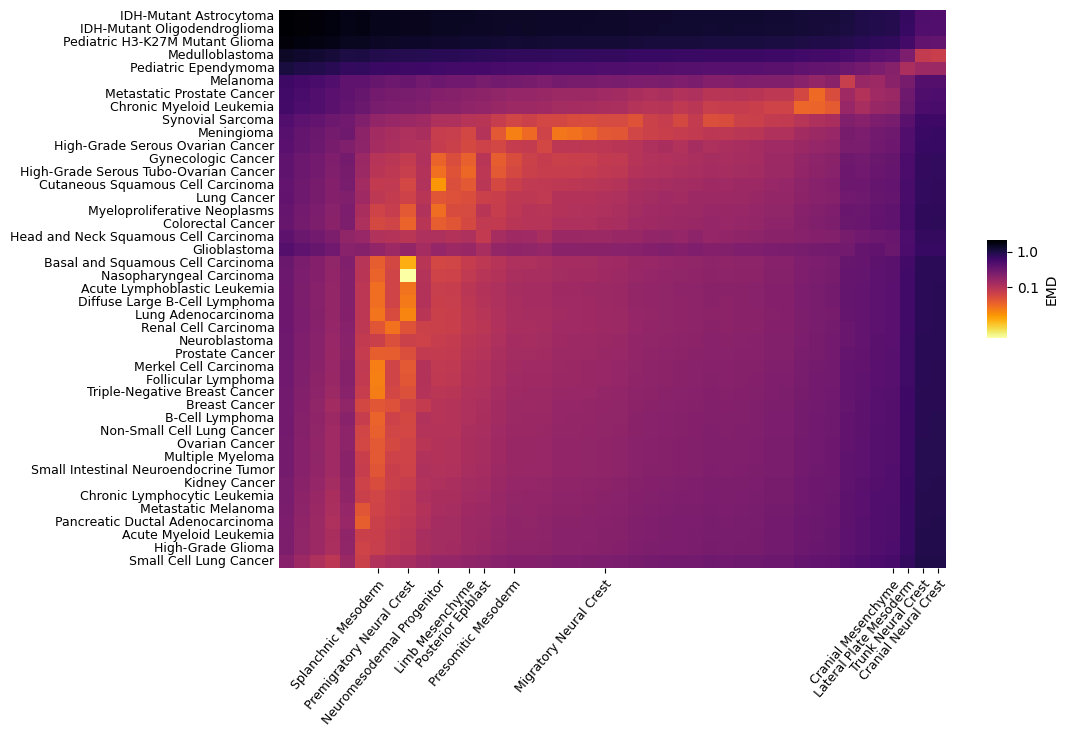

In [8]:
fs = 9
fig, ax = plt.subplots(1, 1, figsize = (10.75, 7.25))
sns.heatmap(df, cmap = 'inferno_r',
            norm = PowerNorm(gamma = .225),
            cbar_kws = {
                'label' : 'EMD',
                'shrink' : .175,
                'aspect' : 5,
                'ticks' : [.1, 1.]},
            ax = ax)

msk_traj = (adata.obs.trajectory == 'True')
cat_traj = adata[msk_traj].obs.category.cat.categories.tolist()
cat_traj.remove('Neuroglial Progenitors')
ax.set_xticks([df.columns.get_loc(cat) + .5 for cat in cat_traj])
ax.set_xticklabels(cat_traj,
                   rotation = 50,
                   rotation_mode = 'anchor',
                   ha = 'right',
                   va = 'top',
                   size = fs)

ax.set_yticks(np.arange(df.shape[0]) + .5)
ax.set_yticklabels(df.index, size = fs)
ax.tick_params('y', size = 0)
ax.invert_xaxis()
ax.invert_yaxis()
plt.show()


/tmp/ipykernel_875484/2504884826.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cancer = adata[msk_cancer].obs.groupby('source_CCCA')


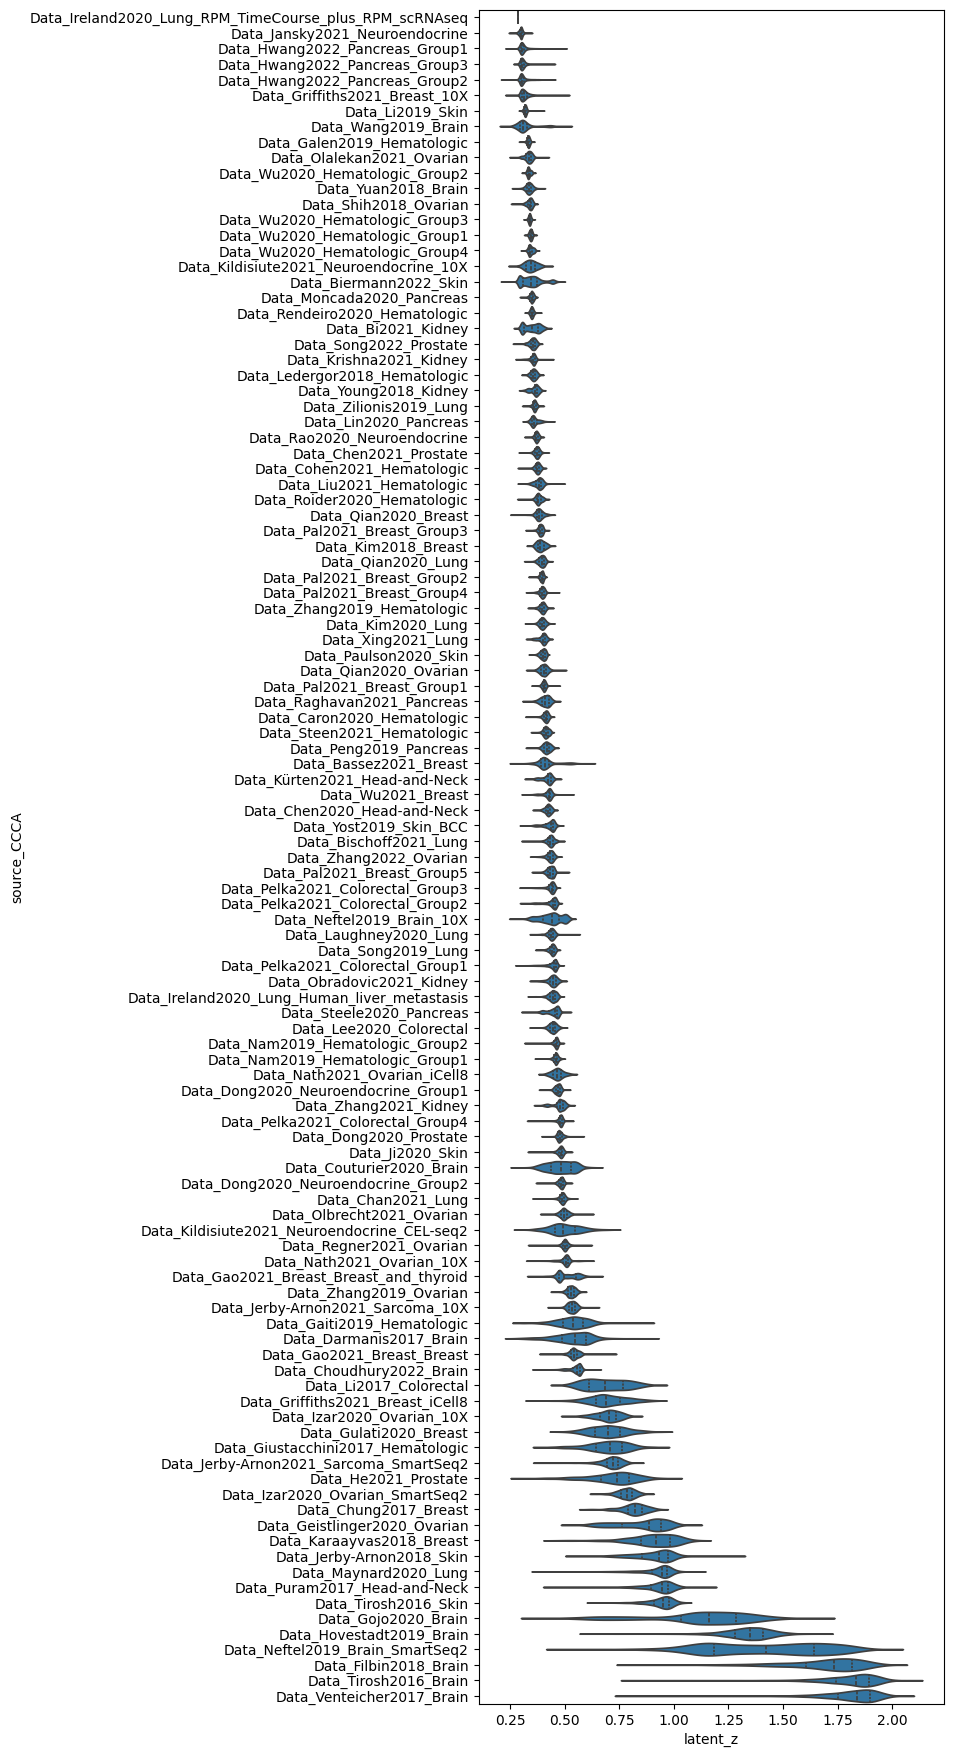

In [66]:
df_cancer = adata[msk_cancer].obs.groupby('source_CCCA')
z_cancer = df_cancer.latent_z.mean()

fig, ax = plt.subplots(1, 1, figsize = (6, 22))
sns.violinplot(
    adata[msk_cancer].obs,
    x = 'latent_z',
    y = 'source_CCCA',
    order = z_cancer.sort_values().index,
    density_norm = 'width',
    inner = 'quart',
    ax = ax)
plt.show()

In [65]:
cv_cancer = df_cancer.latent_z.std() / z_cancer
cv_cancer.sort_values(ascending = False).head()

source_CCCA
Data_Gojo2020_Brain                0.206223
Data_Neftel2019_Brain_SmartSeq2    0.186741
Data_Darmanis2017_Brain            0.156957
Data_He2021_Prostate               0.151588
Data_Wang2019_Brain                0.141179
Name: latent_z, dtype: float32